In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. Preprocessing

In [2]:
movie_lines = open('../input/cornell-movie-dataset/cornell/movie_lines.txt', encoding='utf-8',
             errors='ignore').read().split('\n')

conversations = open('../input/cornell-movie-dataset/cornell/movie_conversations.txt', encoding='utf-8',
             errors='ignore').read().split('\n')


convList = []
for conver in conversations:
    convList.append(conver.split(' +++$+++ ')[-1][1:-1].replace("'", " ").replace(",","").split())

diag = {}
for line in movie_lines:
    diag[line.split(' +++$+++ ')[0]] = line.split(' +++$+++ ')[-1]

## delete
del(movie_lines, conversations, conver, line)

questions = []
answers = []

for conver in convList:
    for i in range(len(conver) - 1):
        questions.append(diag[conver[i]])
        answers.append(diag[conver[i+1]])

## delete
del(diag, convList, conver, i)


###############################
#        max_len = 20        #
###############################

sorted_ques = []
sorted_ans = []
for i in range(len(questions)):
    if len(questions[i]) < 20:
        sorted_ques.append(questions[i])
        sorted_ans.append(answers[i])



def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "can not", txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt

clean_ques = []
clean_ans = []

for line in sorted_ques:
    clean_ques.append(clean_text(line))
        
for line in sorted_ans:
    clean_ans.append(clean_text(line))



## delete
del(answers, questions, line)



for i in range(len(clean_ans)):
    clean_ans[i] = ' '.join(clean_ans[i].split()[:11])



###############################
#                             #
###############################

del(sorted_ans, sorted_ques)


## trimming
clean_ans=clean_ans[:30000]
clean_ques=clean_ques[:30000]
## delete


###  count occurences ###
word2count = {}

for line in clean_ques:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1
for line in clean_ans:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

## delete
del(word, line)


###  remove less frequent ###
thresh = 5

vocab = {}
word_num = 0
for word, count in word2count.items():
    if count >= thresh:
        vocab[word] = word_num
        word_num += 1
        
## delete
del(word2count, word, count, thresh)       
del(word_num)        



for i in range(len(clean_ans)):
    clean_ans[i] = '<SOS> ' + clean_ans[i] + ' <EOS>'



tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocab)
for token in tokens:
    vocab[token] = x
    x += 1
    
    

vocab['cameron'] = vocab['<PAD>']
vocab['<PAD>'] = 0

## delete
del(token, tokens) 
del(x)

### inv answers dict ###
inv_vocab = {w:v for v, w in vocab.items()}



## delete
del(i)



encoder_inp = []
for line in clean_ques:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])
        
    encoder_inp.append(lst)

decoder_inp = []
for line in clean_ans:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])        
    decoder_inp.append(lst)

### delete
del(clean_ans, clean_ques, line, lst, word)






from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_inp = pad_sequences(encoder_inp, 20, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, 20, padding='post', truncating='post')




decoder_final_output = []
for i in decoder_inp:
    decoder_final_output.append(i[1:]) 

decoder_final_output = pad_sequences(decoder_final_output, 20, padding='post', truncating='post')


del(i)

from tensorflow.keras.utils import to_categorical
decoder_final_output = to_categorical(decoder_final_output, len(vocab))



print(decoder_final_output.shape)


(30000, 20, 3166)


# 2. Model Implementaion

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input


enc_inp = Input(shape=(20, ))
dec_inp = Input(shape=(20, ))


VOCAB_SIZE = len(vocab)
embed = Embedding(VOCAB_SIZE+1, output_dim=50, 
                  input_length=20,
                  trainable=True                  
                  )


enc_embed = embed(enc_inp)
enc_lstm = LSTM(400, return_sequences=True, return_state=True)
enc_op, h, c = enc_lstm(enc_embed)
enc_states = [h, c]



dec_embed = embed(dec_inp)
dec_lstm = LSTM(400, return_sequences=True, return_state=True)
dec_op, _, _ = dec_lstm(dec_embed, initial_state=enc_states)

dense = Dense(VOCAB_SIZE, activation='softmax')

dense_op = dense(dec_op)

model = Model([enc_inp, dec_inp], dense_op)




model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')









In [4]:

history=model.fit([encoder_inp, decoder_inp],decoder_final_output,epochs=30,validation_split=0.2)



Epoch 1/30
750/750 [==============================] - 22s 30ms/step - loss: 2.1038 - acc: 0.6627 - val_loss: 1.8813 - val_acc: 0.6865
Epoch 2/30
750/750 [==============================] - 20s 27ms/step - loss: 1.8410 - acc: 0.6890 - val_loss: 1.7715 - val_acc: 0.7008
Epoch 3/30
750/750 [==============================] - 20s 27ms/step - loss: 1.7469 - acc: 0.6981 - val_loss: 1.7219 - val_acc: 0.7058
Epoch 4/30
750/750 [==============================] - 20s 27ms/step - loss: 1.6926 - acc: 0.7015 - val_loss: 1.6952 - val_acc: 0.7083
Epoch 5/30
750/750 [==============================] - 20s 27ms/step - loss: 1.6531 - acc: 0.7036 - val_loss: 1.6791 - val_acc: 0.7099
Epoch 6/30
750/750 [==============================] - 20s 27ms/step - loss: 1.6196 - acc: 0.7056 - val_loss: 1.6682 - val_acc: 0.7112
Epoch 7/30
750/750 [==============================] - 20s 27ms/step - loss: 1.5887 - acc: 0.7074 - val_loss: 1.6636 - val_acc: 0.7118
Epoch 8/30
750/750 [==============================] - 20s 26ms

KeyError: 'accuracy'

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


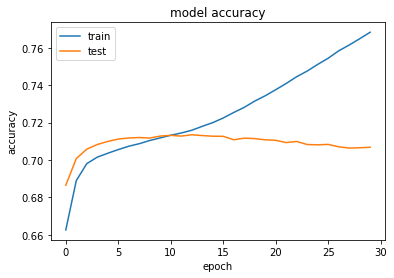

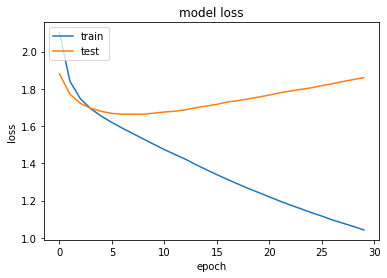

In [5]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Inference Model

In [6]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


enc_model = Model([enc_inp], enc_states)



# decoder Model
decoder_state_input_h = Input(shape=(400,))
decoder_state_input_c = Input(shape=(400,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_outputs, state_h, state_c = dec_lstm(dec_embed , 
                                    initial_state=decoder_states_inputs)


decoder_states = [state_h, state_c]


dec_model = Model([dec_inp]+ decoder_states_inputs,
                                      [decoder_outputs]+ decoder_states)




In [7]:
import numpy as np


from keras.preprocessing.sequence import pad_sequences
print("##########################################")
print("#       start chatting ver. 1.0          #")
print("##########################################")


prepro1 = ""
while prepro1 != 'q':
    prepro1  = input("you : ")
    ## prepro1 = "Hello"

    prepro1 = clean_text(prepro1)
    ## prepro1 = "hello"

    prepro = [prepro1]
    ## prepro1 = ["hello"]

    txt = []
    for x in prepro:
        # x = "hello"
        lst = []
        for y in x.split():
            ## y = "hello"
            try:
                lst.append(vocab[y])
                ## vocab['hello'] = 454
            except:
                lst.append(vocab['<OUT>'])
        txt.append(lst)

    ## txt = [[454]]
    txt = pad_sequences(txt, 20, padding='post')

    ## txt = [[454,0,0,0,.........20]]

    stat = enc_model.predict( txt )

    empty_target_seq = np.zeros( ( 1 , 1) )
     ##   empty_target_seq = [0]


    empty_target_seq[0, 0] = vocab['<SOS>']
    ##    empty_target_seq = [255]

    stop_condition = False
    decoded_translation = ''

    while not stop_condition :

        dec_outputs , h, c= dec_model.predict([ empty_target_seq] + stat )
        decoder_concat_input = dense(dec_outputs)
        ## decoder_concat_input = [0.1, 0.2, .4, .0, ...............]

        sampled_word_index = np.argmax( decoder_concat_input[0, -1, :] )
        ## sampled_word_index = [2]

        sampled_word = inv_vocab[sampled_word_index] + ' '

        ## inv_vocab[2] = 'hi'
        ## sampled_word = 'hi '

        if sampled_word != '<EOS> ':
            decoded_translation += sampled_word  

        if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 20:
            stop_condition = True 

        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        ## <SOS> - > hi
        ## hi --> <EOS>
        stat = [h, c]  

    print("chatbot attention : ", decoded_translation )
    print("==============================================")  

Using TensorFlow backend.


##########################################
#       start chatting ver. 1.0          #
##########################################


you :  Hello!


chatbot attention :  i am not sure 


you :  How are you


chatbot attention :  i am not gonna bullshit you 


you :  okay.


chatbot attention :  i am not gonna bullshit you 


you :  calm down


chatbot attention :  i am not gonna bullshit you 


you :  let go of it


chatbot attention :  i am not gonna bullshit you 


you :  let go


chatbot attention :  i am not gonna bullshit you 


you :  what?


chatbot attention :  i am not gonna bullshit you 


you :  got you.


chatbot attention :  i am not sure 


you :  good night


chatbot attention :  i am not gonna bullshit you 


you :  take care


chatbot attention :  i am not sure 


you :  bye


chatbot attention :  yes 


you :  q


chatbot attention :  <OUT> 
